In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Loading the Data & Forming the Dataframe

In [2]:
local_path_target = '/mnt/g/Meine Ablage/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/wind_hourly_clean.csv"

data_target = pd.read_csv(local_path_target)
data_feature = pd.read_csv(local_path_feature, index_col=0)

data_target['Date'] = pd.to_datetime(data_target.Date)

In [3]:
data_target.head()

,Date,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
0,2015-01-01 00:00:00,48.0,3641.0,0.0,50hertz
1,2015-01-01 01:00:00,48.0,4016.0,0.0,50hertz
2,2015-01-01 02:00:00,48.0,4232.0,0.0,50hertz
3,2015-01-01 03:00:00,48.0,3994.0,0.0,50hertz
4,2015-01-01 04:00:00,48.0,3809.0,0.0,50hertz


In [4]:
type(data_target["Date"][1])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
generation_df = data_target.groupby(by=data_target['Date']).sum()
generation_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [6]:
wind_df = generation_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
wind_df.head(3)

Date
2015-01-01 00:00:00    8646.0
2015-01-01 01:00:00    8816.0
2015-01-01 02:00:00    9058.0
dtype: float64

In [7]:
wind_df.isna().sum()

0

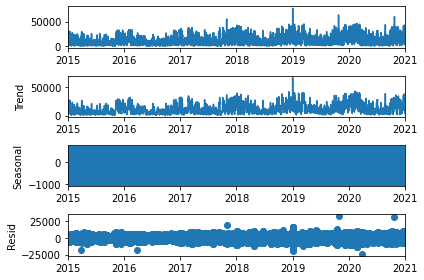

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_add = seasonal_decompose(wind_df, model = "additive")
decomp_add.plot();

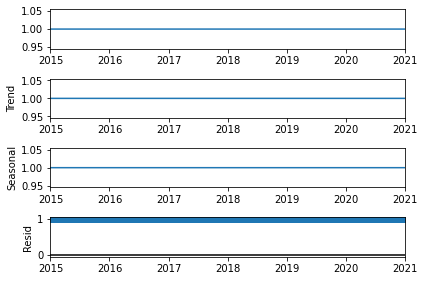

In [9]:

decomp_mul = seasonal_decompose(wind_df >= 0 , model = "multiplicative")
decomp_mul.plot();

In [8]:
type(data_target.index[1])

int

In [9]:
data_feature.index[1]

'2015-01-01 01:00:00'

In [10]:
data_feature.index = pd.to_datetime(data_feature.index)
data_feature.head()

,90,125,161,164,183,197,198,232,282,298,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,7.0,...,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,7.4,...,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,7.1,...,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6
2015-01-01 03:00:00,2.0,0.7,1.4,3.7,12.4,3.2,3.5,1.5,0.6,6.9,...,4.2,1.1,4.2,2.5,5.4,3.2,0.7,1.1,1.0,2.8
2015-01-01 04:00:00,1.1,0.9,1.7,4.2,12.2,3.2,3.4,1.7,1.0,6.0,...,4.4,0.9,4.1,1.8,6.1,3.6,0.8,0.9,1.4,2.8


In [8]:
data_feat_mean = data_feature.mean(axis=1)
data_feat_mean_log = np.log(data_feature.mean(axis=1))

In [9]:
exog_1 = data_feat_mean.loc["2020-01-01 00:00:00":'2020-12-16 00:00:00']

In [10]:
exog_1_test = data_feat_mean.loc["2020-12-16 01:00:00" :'2020-12-31 00:00:00']

In [11]:
exog_test_2w = data_feat_mean.loc['2016-01-01 00:00:00':'2016-01-15 00:00:00']

## Statistical Exploration

### Building Test, Train set

In [12]:
wind_df_train = wind_df.loc[dt.date(2020,1,1):dt.date(2020,12,16)]
wind_df_test = wind_df.loc[dt.date(2020,12,16):dt.date(2020,12,31)]

#wind_df_train_log = np.log(wind_df.loc[:dt.date(2016,1,1)])
#wind_df_test_log = np.log(wind_df.loc[dt.date(2016,1,1):dt.date(2016,3,1)])

In [13]:
wind_df_test.index

DatetimeIndex(['2020-12-16 00:00:00', '2020-12-16 01:00:00',
               '2020-12-16 02:00:00', '2020-12-16 03:00:00',
               '2020-12-16 04:00:00', '2020-12-16 05:00:00',
               '2020-12-16 06:00:00', '2020-12-16 07:00:00',
               '2020-12-16 08:00:00', '2020-12-16 09:00:00',
               ...
               '2020-12-30 15:00:00', '2020-12-30 16:00:00',
               '2020-12-30 17:00:00', '2020-12-30 18:00:00',
               '2020-12-30 19:00:00', '2020-12-30 20:00:00',
               '2020-12-30 21:00:00', '2020-12-30 22:00:00',
               '2020-12-30 23:00:00', '2020-12-31 00:00:00'],
              dtype='datetime64[ns]', name='Date', length=361, freq=None)

In [14]:
wind_df_test=wind_df_test.drop(wind_df_test.index[0])
wind_df_test.head()

Date
2020-12-16 01:00:00    6841.0
2020-12-16 02:00:00    5824.0
2020-12-16 03:00:00    4839.0
2020-12-16 04:00:00    4087.0
2020-12-16 05:00:00    3896.0
dtype: float64

In [15]:
wind_df_train.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-15 15:00:00', '2020-12-15 16:00:00',
               '2020-12-15 17:00:00', '2020-12-15 18:00:00',
               '2020-12-15 19:00:00', '2020-12-15 20:00:00',
               '2020-12-15 21:00:00', '2020-12-15 22:00:00',
               '2020-12-15 23:00:00', '2020-12-16 00:00:00'],
              dtype='datetime64[ns]', name='Date', length=8401, freq=None)

In [16]:
wind_df_test_2w = wind_df.loc[dt.date(2016,1,1):dt.date(2016,1,15)]

In [17]:
wind_df_test_2w.tail()

Date
2016-01-14 20:00:00    10499.0
2016-01-14 21:00:00    10394.0
2016-01-14 22:00:00     9929.0
2016-01-14 23:00:00     9749.0
2016-01-15 00:00:00     9662.0
dtype: float64

<AxesSubplot:>

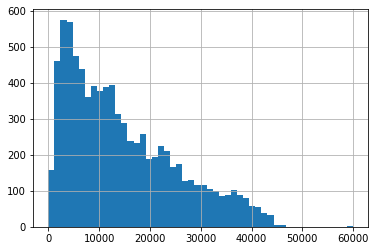

In [18]:
wind_df_train.hist(bins=50)

Text(0, 0.5, 'Energy generation by in MW/H')

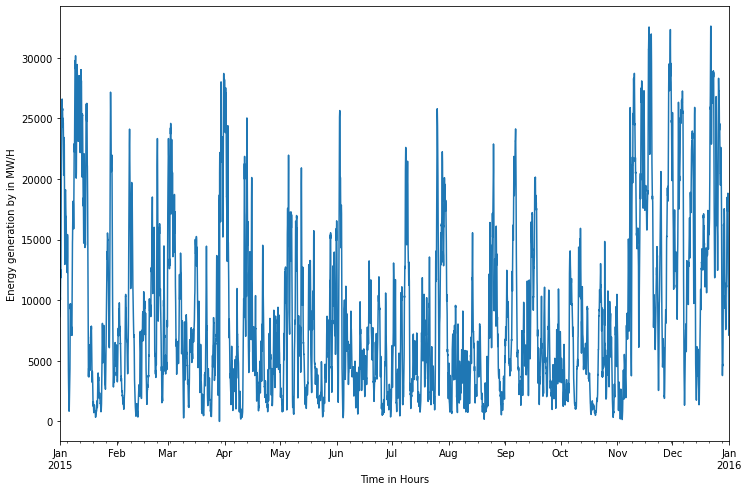

In [21]:
plt.subplots(figsize=(12,8))
wind_df_train.plot()
plt.xlabel("Time in Hours")
plt.ylabel("Energy generation by in MW/H")

In [22]:
adfuller(wind_df_train)[1]

9.013654849711734e-12

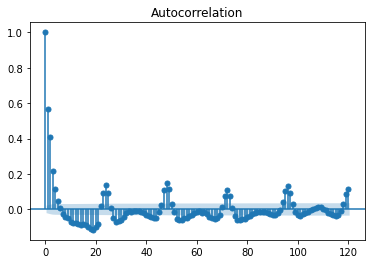

In [23]:
plot_acf(wind_df_train.diff(1).dropna(), lags=120);

In [24]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m)
    if d > 0:
        for i in range(d):
            y = y.diff(1)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 60, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

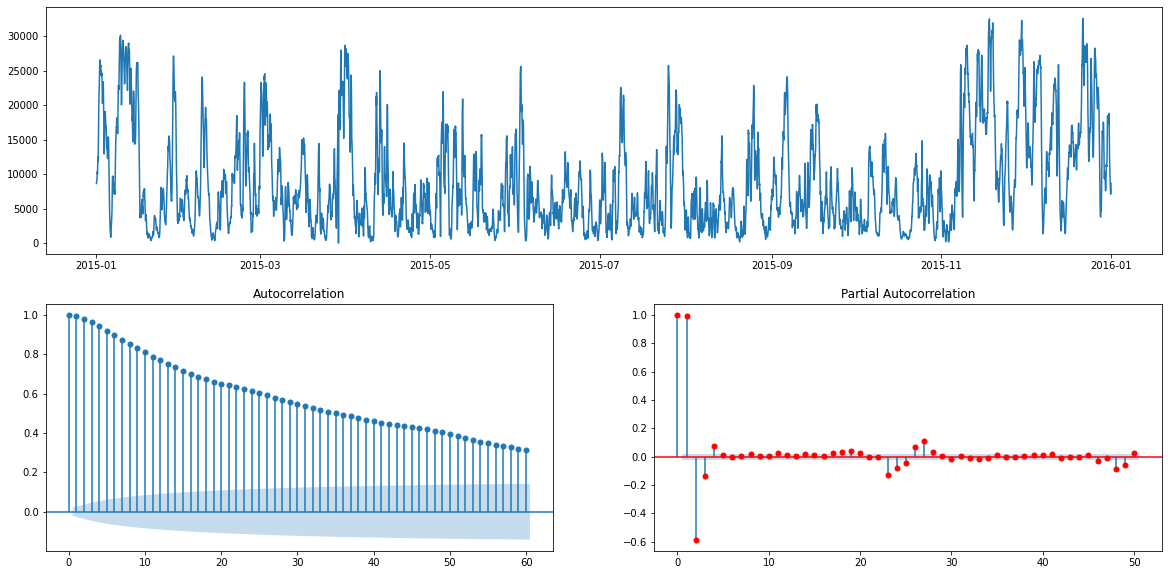

In [25]:
plot_autocorrelation(wind_df_train, D=0, m=365*5)

Format to code if we need to tun it again /n
import pmdarima as pm

smodel = pm.auto_arima(wind_df_train, m=12, X=exog_1.to_numpy().reshape(-1,1),
                       #start_p=0, max_p=2,
                       #start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

In [55]:
# Order Parameters of best model with exog wind speed and hourly data, non logarithmic data, 1 year timeframe 2015 - 2016
bm_order = (1,1,2)
# 24 as last parameter because ACF plot shows a recurring theme once a day
bm_seasonal_order = (2,0,0,12)

## Model

In [56]:
sarimax = SARIMAX(endog=wind_df_train, exog=exog_1, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [57]:
wind_df_test.shape

(360,)

In [58]:
y_pred = sarimax.forecast(wind_df_test.shape[0], exog=exog_1_test)[0]

In [59]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [60]:
forecast = sarimax.forecast(len(wind_df_test), exog=exog_1_test, alpha=0.05)

In [61]:
forecast

2020-12-16 01:00:00    7958.884572
2020-12-16 02:00:00    7415.938548
2020-12-16 03:00:00    6901.033033
2020-12-16 04:00:00    6416.713097
2020-12-16 05:00:00    6368.423104
                          ...     
2020-12-30 20:00:00    7247.176249
2020-12-30 21:00:00    7334.943301
2020-12-30 22:00:00    7324.723850
2020-12-30 23:00:00    7357.786781
2020-12-31 00:00:00    7259.800277
Freq: H, Name: predicted_mean, Length: 360, dtype: float64

In [62]:
wind_df_test

Date
2020-12-16 01:00:00     6841.0
2020-12-16 02:00:00     5824.0
2020-12-16 03:00:00     4839.0
2020-12-16 04:00:00     4087.0
2020-12-16 05:00:00     3896.0
                        ...   
2020-12-30 20:00:00    21598.0
2020-12-30 21:00:00    21911.0
2020-12-30 22:00:00    21506.0
2020-12-30 23:00:00    21077.0
2020-12-31 00:00:00    20572.0
Length: 360, dtype: float64

In [63]:
(forecast - wind_df_test).mean()

-12422.62924135109

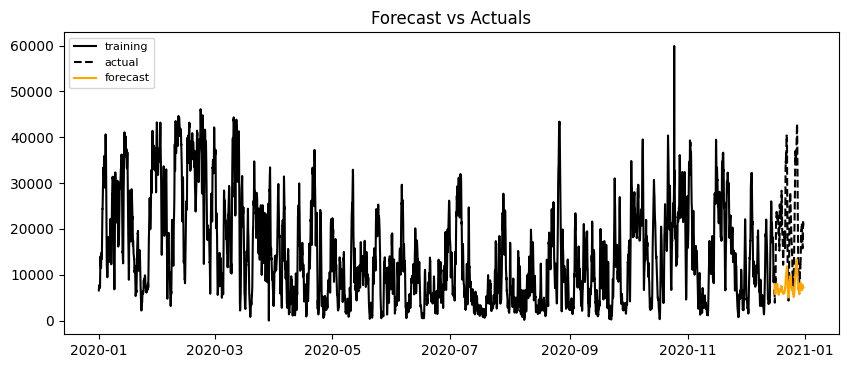

In [64]:
plot_forecast(forecast, wind_df_train, wind_df_test)

In [19]:
type(wind_df_train)

pandas.core.series.Series

In [65]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
hourly_baseline = mean_absolute_percentage_error(wind_df_test, forecast)
hourly_baseline

56.1423584157171

In [67]:
np.exp(y_test) - np.exp(forecast)

NameError: name 'y_test' is not defined

In [ ]:
hourly_baseline_log = mean_absolute_percentage_error(np.log(wind_df_test), np.log(forecast))
hourly_baseline_log

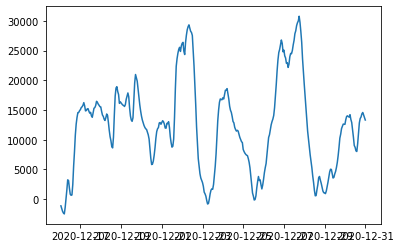

In [68]:
plt.plot(wind_df_test - forecast)

### Predicting accuracy with 2 week test set

In [50]:
forecast_2w = sarimax.forecast(len(wind_df_test_2w), exog=exog_test_2w, alpha=0.05)

NameError: name 'wind_df_test_2w' is not defined

In [51]:
hourly_baseline_2w = mean_absolute_percentage_error(wind_df_test_2w, forecast_2w)
hourly_baseline_2w

NameError: name 'wind_df_test_2w' is not defined

## New Model trained with Air Pressure Data

### Importing the Air pressure data

In [37]:
local_path_feature_2 = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/hourly_airp_df.csv"
data_feature_2 = pd.read_csv(local_path_feature, index_col=0)

In [38]:
data_feature_2.head()

,90,125,161,164,183,197,198,232,282,298,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,7.0,...,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,7.4,...,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,7.1,...,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6
2015-01-01 03:00:00,2.0,0.7,1.4,3.7,12.4,3.2,3.5,1.5,0.6,6.9,...,4.2,1.1,4.2,2.5,5.4,3.2,0.7,1.1,1.0,2.8
2015-01-01 04:00:00,1.1,0.9,1.7,4.2,12.2,3.2,3.4,1.7,1.0,6.0,...,4.4,0.9,4.1,1.8,6.1,3.6,0.8,0.9,1.4,2.8


In [39]:
data_feat2_mean = data_feature_2.mean(axis=1)

In [40]:
exog_2 = data_feat_mean.loc["2020-01-01 00:00:00":'2020-12-16 00:00:00']

In [41]:
exog_2_test = data_feat_mean.loc["2020-12-16 01:00:00" :'2020-12-31 00:00:00']

In [42]:
exog_2_test_2w = data_feat_mean.loc['2016-01-01 00:00:00':'2016-01-15 00:00:00']

### Training_new_Model

In [69]:
sarimax_exog2 = SARIMAX(endog=wind_df_train, exog=exog_2, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [70]:
# Making a forecast#
forecast_exog2 = sarimax_exog2.forecast(wind_df_test_2w.shape[0], exog=exog_2_test_2w )[0]

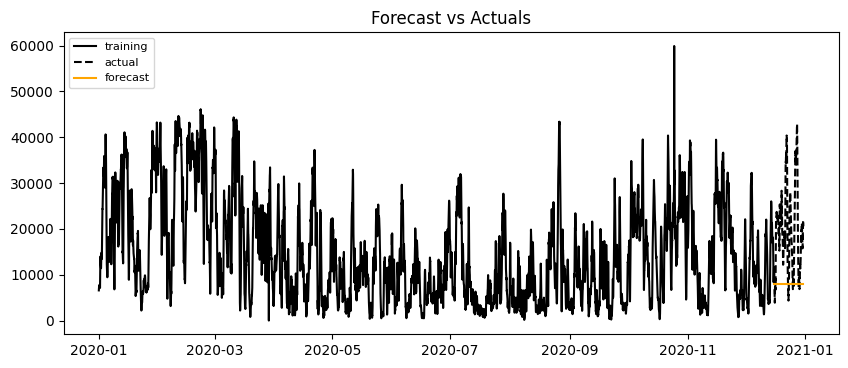

In [71]:
plot_forecast(forecast_exog2, wind_df_train, wind_df_test)

In [72]:
mape_exog_2 = mean_absolute_percentage_error(wind_df_test, forecast_exog2)
mape_exog_2

53.23244428663233

In [73]:
mape2w_exog_2 = mean_absolute_percentage_error(wind_df_test_2w, forecast_exog2)
mape2w_exog_2

53.882576397177864

### Combining both Exogenous Timeseries 

In [74]:
exog_12 = pd.concat([exog_1, exog_2], axis=1)

In [75]:
exog_12

,0,1
Date,,
2020-01-01 00:00:00,2.390769,2.390769
2020-01-01 01:00:00,2.434231,2.434231
2020-01-01 02:00:00,2.441538,2.441538
2020-01-01 03:00:00,2.361538,2.361538
2020-01-01 04:00:00,2.400769,2.400769
...,...,...
2020-12-15 20:00:00,2.955385,2.955385
2020-12-15 21:00:00,2.884231,2.884231
2020-12-15 22:00:00,2.833077,2.833077


In [76]:
exog_12_test = pd.concat([exog_1_test, exog_2_test], axis=1)

In [77]:
sarimax_exog12 = SARIMAX(endog=wind_df_train, exog=exog_12, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [78]:
forecast_exog12 = sarimax_exog12.forecast(wind_df_test.shape[0], exog=exog_12_test )[0]

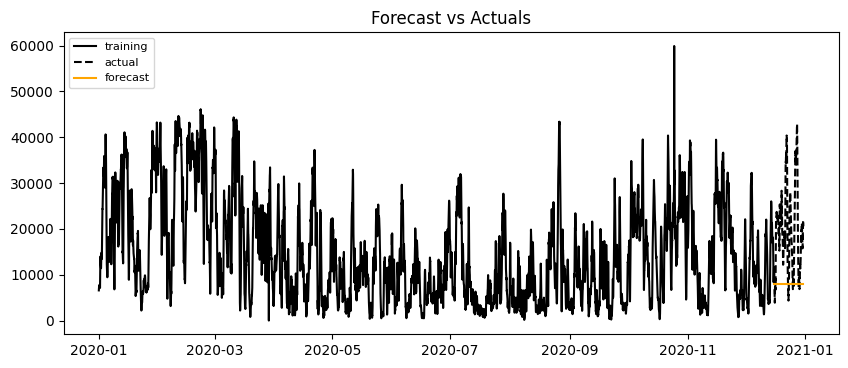

In [79]:
plot_forecast(forecast_exog12, wind_df_train, wind_df_test)

In [80]:
mape_exog_2 = mean_absolute_percentage_error(wind_df_test, forecast_exog12)
mape_exog_2

53.41888524174628

## Getting the oficial MAPE 
for the official prediction in the same timeframe

In [82]:
local_path_forcasted = '/mnt/g/Meine Ablage/raw_data/Target/Hourly/forecasted_generation_data/df_deutschland_forecasted.csv'

data_forcasted = pd.read_csv(local_path_target)

data_forcasted['Date'] = pd.to_datetime(data_forcasted.Date)

In [83]:
forcasted_df = data_forcasted.groupby(by=data_forcasted['Date']).sum()
forcasted_df.head(3)

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [84]:
forcasted_wind_df = forcasted_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
forcasted_wind_df.head(3)

Date
2015-01-01 00:00:00    8646.0
2015-01-01 01:00:00    8816.0
2015-01-01 02:00:00    9058.0
dtype: float64

In [85]:
# Creating y_pred with the same Timeframe
forcasted_wind_df_test = forcasted_wind_df.loc[dt.date(2020,12,16):dt.date(2020,12,31)]
forcasted_wind_df_test = forcasted_wind_df_test.drop(forcasted_wind_df_test.index[0])
forcasted_wind_df_test.head()

Date
2020-12-16 01:00:00    6841.0
2020-12-16 02:00:00    5824.0
2020-12-16 03:00:00    4839.0
2020-12-16 04:00:00    4087.0
2020-12-16 05:00:00    3896.0
dtype: float64

In [87]:
forcasted_wind_df_test.shape

(360,)

In [88]:
wind_df_test.shape

(360,)

In [90]:
mean_absolute_percentage_error(wind_df_test, forcasted_wind_df_test)

0.0

In [91]:
forcasted_wind_df

Date
2015-01-01 00:00:00    8646.0
2015-01-01 01:00:00    8816.0
2015-01-01 02:00:00    9058.0
2015-01-01 03:00:00    9071.0
2015-01-01 04:00:00    9168.0
                        ...  
2021-01-01 19:00:00    4845.0
2021-01-01 20:00:00    5028.0
2021-01-01 21:00:00    5204.0
2021-01-01 22:00:00    5681.0
2021-01-01 23:00:00    5333.0
Length: 52632, dtype: float64

In [95]:
wind_df.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2021-01-01 14:00:00', '2021-01-01 15:00:00',
               '2021-01-01 16:00:00', '2021-01-01 17:00:00',
               '2021-01-01 18:00:00', '2021-01-01 19:00:00',
               '2021-01-01 20:00:00', '2021-01-01 21:00:00',
               '2021-01-01 22:00:00', '2021-01-01 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=52632, freq=None)

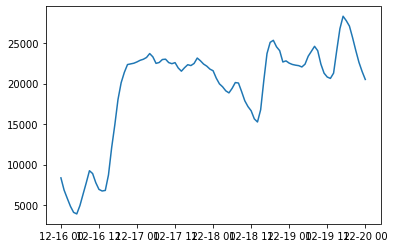

In [97]:
plt.plot(wind_df["2020-12-16 00:00:00":"2020-12-20 00:00:00"])